<a href="https://colab.research.google.com/github/AlmaBasic/Artificial-intelligence/blob/main/Vjezba_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install torch torchvision -U
!pip install librosa matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 117.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 104.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [1]:
import torch

print(torch.__version__)

2.6.0+cu124


In [2]:
import os
import wave
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
import soundfile as sf
import librosa.display
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!ls "/content/drive/MyDrive/train/audio"

_background_noise_  dog    four   left	  off	 seven	 three	wow
bed		    down   go	  marvin  on	 sheila  tree	yes
bird		    eight  happy  nine	  one	 six	 two	zero
cat		    five   house  no	  right  stop	 up


In [5]:
path = "/content/drive/MyDrive/train/audio"
classes = os.listdir(path)

In [6]:
classes.remove('_background_noise_')

In [13]:
data = []
classes_ = []
filename = []
duration_length = []


In [14]:
for class_ in classes:
    class_files = os.listdir(os.path.join(path, class_))
    for file_name in class_files:
        full_filename = os.path.join(path, class_, file_name)
        filename.append(full_filename)

        y, sr = librosa.load(full_filename, sr=16000)
        duration = librosa.get_duration(y=y, sr=sr)
        classes_.append(class_)

        duration_length.append(duration)

In [15]:
duration_length[:10]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [16]:
filename[:10]

['/content/drive/MyDrive/train/audio/bed/1365dd89_nohash_0.wav',
 '/content/drive/MyDrive/train/audio/bed/97e0c576_nohash_2.wav',
 '/content/drive/MyDrive/train/audio/bed/ac652c60_nohash_0.wav',
 '/content/drive/MyDrive/train/audio/bed/23ad12d8_nohash_0.wav',
 '/content/drive/MyDrive/train/audio/bed/161fcca8_nohash_1.wav',
 '/content/drive/MyDrive/train/audio/bed/a19452d5_nohash_1.wav',
 '/content/drive/MyDrive/train/audio/bed/b72e58c9_nohash_0.wav',
 '/content/drive/MyDrive/train/audio/bed/e3411931_nohash_0.wav',
 '/content/drive/MyDrive/train/audio/bed/1528225c_nohash_3.wav',
 '/content/drive/MyDrive/train/audio/bed/1706c35f_nohash_3.wav']

In [17]:
df = pd.DataFrame({'Filename': filename, 'Class': classes_, 'Duration': duration_length})

In [18]:
df.head()

,Filename,Class,Duration
0,/content/drive/MyDrive/train/audio/bed/1365dd8...,bed,1.0
1,/content/drive/MyDrive/train/audio/bed/97e0c57...,bed,1.0
2,/content/drive/MyDrive/train/audio/bed/ac652c6...,bed,1.0
3,/content/drive/MyDrive/train/audio/bed/23ad12d...,bed,1.0
4,/content/drive/MyDrive/train/audio/bed/161fcca...,bed,1.0


In [19]:
df.shape

(63258, 3)

In [21]:
audio_path = df.Filename[0]

In [22]:
audio_path

'/content/drive/MyDrive/train/audio/bed/1365dd89_nohash_0.wav'

In [23]:
if not os.path.exists(audio_path):
    raise FileNotFoundError(f"Fajl nije pronađen: {audio_path}")

In [24]:
y, sr = librosa.load(audio_path)

In [25]:
import os
print(os.listdir())

['.config', 'drive', 'sample_data']


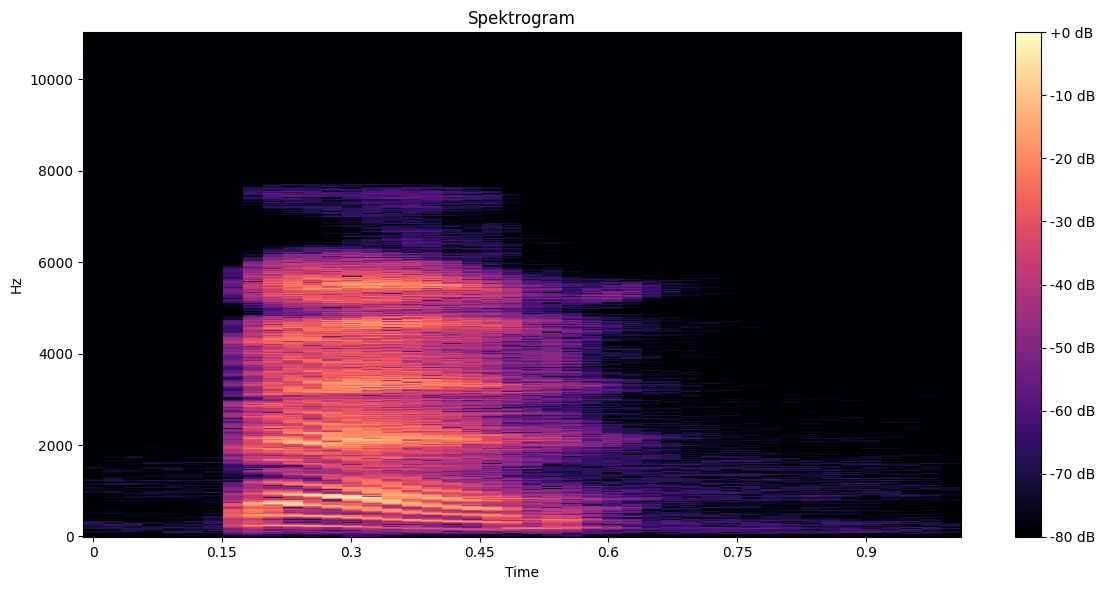

In [26]:
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure(figsize=(12, 6))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Spektrogram')
plt.tight_layout()
plt.show()

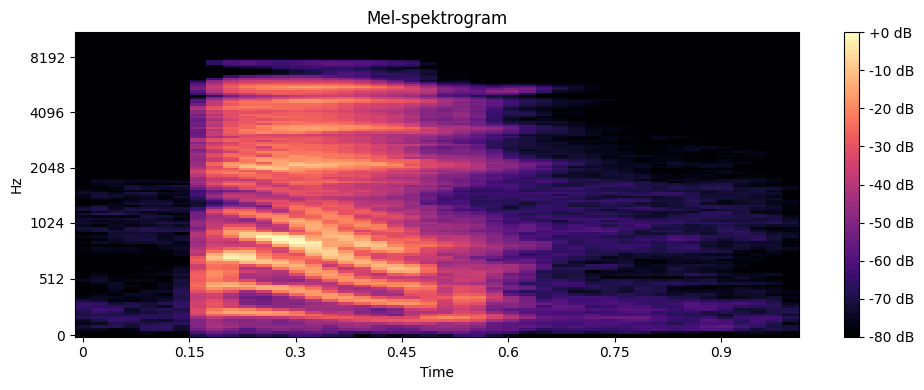

In [27]:
# 2. Generisanje mel-spektrograma
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)

# 3. Konverzija u log-skalirani spektrogram (decibeli)
S_dB = librosa.power_to_db(S, ref=np.max)

# 4. Prikaz spektrograma
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-spektrogram')
plt.tight_layout()
plt.show()